### Introduction


**Probelm Statement:** Make a classifier which takes in a job description and gives the department name for it.
*   Use a neural network model
*   Make use of a pre-trained Word Embeddings (example: Word2Vec, GloVe, etc.)
*   Calculate the accuracy on a test set (data not used to train the model)

**Problem Solving Approach:** 
_Provide a brief description of steps you followed for solving this problem_
1. Visualise the dataset to understand it
2. Create a Neural Network model and check its accuracy.
3. Use pre-trained model (GloVe) and check that's accuracy.

### Part I: Text Preprocessing

_Include all text preprocesing steps like processing of json,csv files & data cleaning in this part._

Import neccessary packages in below cell

In [185]:
import pandas as pd
import numpy as np
import json
import os
import matplotlib.pyplot as plt
import sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

In [186]:
path_json = 'Spotmentor/data/docs'
path_csv = 'Spotmentor/data'
file_csv = os.path.join(path_csv, 'document_departments.csv')

In [187]:
obj = json.load(open(os.path.join(path_json, str(data['Document ID'][62]) + '.json')))
obj.keys()

dict_keys(['company_info', 'api_data', 'other_details', 'topbox_information', 'jd_information', '_id'])

### Part II: Exploratoty Data Analysis

_Include EDA steps like finding distribution of Departments in this part, you may also use plots for EDA._

In [188]:
data['count'] = data['Department'].map(lambda c_row: 1 if isinstance(c_row, str) else 0)
img_id = data.groupby('Department').agg({'count': 'sum'}).reset_index()

In [189]:
depart_map = {}
for i in range(len(img_id)):
    depart_map[img_id['Department'][i]] = i+1

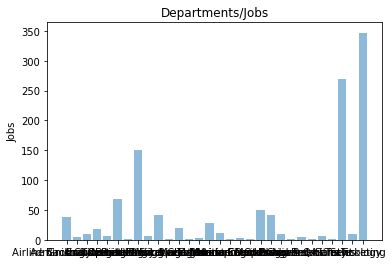

In [190]:
y_pos = np.arange(len(img_id))
objects = img_id['Department']
performance = img_id['count']
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Jobs')
plt.title('Departments/Jobs')

plt.show()

In [191]:
n = len(data)
label = []
keyword = []

In [192]:
for i in range(n):
    obj = json.load(open(os.path.join(path_json, str(data['Document ID'][i]) + '.json')))
    department = obj['other_details']['Department:']
    title = obj['api_data']['job_title']
    obj = obj['api_data']['job_keywords']
    st = [st.strip(' ') for st in obj]
    dp = [dp.strip(' ') for dp in department]
    tt = [tt.strip(' ') for tt in title]
    st = st + dp + tt
    str_join = ",".join(st)
    label.append(depart_map[data['Department'][i]])
    keyword.append(str_join)

In [193]:
df = pd.DataFrame(label, columns=['label'])
df2 = pd.DataFrame(keyword, columns=['keyword'])
df = df.merge(df2, left_index=True, right_index=True)
df.head()

,label,keyword
0,6,"telesales,telemarketing,communication,call cen..."
1,8,"internet media,facebook marketing,online adver..."
2,28,"immigration,canada pr,australia pr,client serv..."
3,4,"documentation,,Back Office Operations,F,r,e,s,..."
4,8,"internet media,facebook marketing,online adver..."


In [194]:
x = df['keyword'].values
y = df['label'].values

### Part III: Modelling & Evaluation

_Include all model prepration & evaluation steps in this part._

In [195]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25)

In [196]:
def hotencode(arr):
    a = np.zeros([len(arr), np.max(arr)])
    for i in range(len(arr)):
        col = arr[i]
        a[i,col-1] = 1
    return a

def hotdecode(arr):
    a = []
    for i in range(len(arr)):
        a.append(np.argmax(arr[i,:])+1)
    return np.asarray(a)

In [197]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(x_train)
X_train = tokenizer.texts_to_sequences(x_train)
X_test = tokenizer.texts_to_sequences(x_test)

In [198]:
y_train_hot = hotencode(y_train)
y_test_hot = hotencode(y_test)

In [199]:
vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index
maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [200]:
from keras.models import Sequential
from keras import layers

embedding_dim = 50

model = Sequential()
model.add(layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=maxlen))
model.add(layers.Flatten())
model.add(layers.Dense(35, activation='relu'))
model.add(layers.Dense(30, activation='sigmoid'))
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, 100, 50)           66700     
_________________________________________________________________
flatten_10 (Flatten)         (None, 5000)              0         
_________________________________________________________________
dense_29 (Dense)             (None, 35)                175035    
_________________________________________________________________
dense_30 (Dense)             (None, 30)                1080      
Total params: 242,815.0
Trainable params: 242,815.0
Non-trainable params: 0.0
_________________________________________________________________


In [201]:
history = model.fit(X_train, y_train_hot, epochs=30, verbose=True, validation_data=(X_test, y_test_hot), batch_size=10)
loss, accuracy = model.evaluate(X_train, y_train_hot, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test_hot, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Train on 871 samples, validate on 291 samples
Epoch 1/30
871/871 [==============================] - 0s - loss: 2.7971 - acc: 0.2113 - val_loss: 2.3638 - val_acc: 0.3024
Epoch 2/30
871/871 [==============================] - 0s - loss: 2.1572 - acc: 0.2974 - val_loss: 1.8953 - val_acc: 0.3024
Epoch 3/30
871/871 [==============================] - 0s - loss: 1.7487 - acc: 0.2974 - val_loss: 1.6350 - val_acc: 0.3024
Epoch 4/30
871/871 [==============================] - 0s - loss: 1.3381 - acc: 0.2974 - val_loss: 1.4154 - val_acc: 0.3024
Epoch 5/30
871/871 [==============================] - 0s - loss: 0.9007 - acc: 0.5488 - val_loss: 0.9451 - val_acc: 0.7766
Epoch 6/30
871/871 [==============================] - 0s - loss: 0.3887 - acc: 0.9047 - val_loss: 0.8133 - val_acc: 0.8110
Epoch 7/30
871/871 [==============================] - 0s - loss: 0.2154 - acc: 0.9529 - val_loss: 0.8037 - val_acc: 0.7973
Epoch 8/30
871/871 [==============================] - 0s - loss: 0.1170 - acc: 0.9828 - val_l

In [202]:
#using GloVe

import numpy as np

def create_embedding_matrix(filepath, word_index, embedding_dim):
    vocab_size = len(word_index) + 1  # Adding again 1 because of reserved 0 index
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    with open(filepath, encoding="utf8") as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word] 
                embedding_matrix[idx] = np.array(vector, dtype=np.float32)[:embedding_dim]

    return embedding_matrix

In [203]:
embedding_dim = 50
embedding_matrix = create_embedding_matrix('Spotmentor/glove.6B/glove.6B.50d.txt',tokenizer.word_index, embedding_dim)

In [204]:
model = Sequential()
model.add(layers.Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], input_length=maxlen, trainable=True))
model.add(layers.GlobalMaxPool1D())
model.add(layers.Dense(35, activation='relu'))
model.add(layers.Dense(30, activation='sigmoid'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_13 (Embedding)     (None, 100, 50)           66700     
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 50)                0         
_________________________________________________________________
dense_31 (Dense)             (None, 35)                1785      
_________________________________________________________________
dense_32 (Dense)             (None, 30)                1080      
Total params: 69,565.0
Trainable params: 69,565.0
Non-trainable params: 0.0
_________________________________________________________________


In [205]:
history = model.fit(X_train, y_train_hot, epochs=30, verbose=True, validation_data=(X_test, y_test_hot), batch_size=10)

loss, accuracy = model.evaluate(X_train, y_train_hot, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test_hot, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Train on 871 samples, validate on 291 samples
Epoch 1/30
871/871 [==============================] - 0s - loss: 2.8228 - acc: 0.2204 - val_loss: 2.2820 - val_acc: 0.2715
Epoch 2/30
871/871 [==============================] - 0s - loss: 2.2725 - acc: 0.2262 - val_loss: 2.1550 - val_acc: 0.2371
Epoch 3/30
871/871 [==============================] - 0s - loss: 2.1879 - acc: 0.2537 - val_loss: 2.0971 - val_acc: 0.3127
Epoch 4/30
871/871 [==============================] - 0s - loss: 2.1296 - acc: 0.3008 - val_loss: 2.0854 - val_acc: 0.3024
Epoch 5/30
871/871 [==============================] - 0s - loss: 2.0644 - acc: 0.2974 - val_loss: 1.9953 - val_acc: 0.3024
Epoch 6/30
871/871 [==============================] - 0s - loss: 1.9620 - acc: 0.2974 - val_loss: 1.8993 - val_acc: 0.3024
Epoch 7/30
871/871 [==============================] - 0s - loss: 1.8458 - acc: 0.3215 - val_loss: 1.7413 - val_acc: 0.5052
Epoch 8/30
871/871 [==============================] - 0s - loss: 1.5559 - acc: 0.5936 - val_l

**Results Summary:**
_Provide a brief summary of results obtained like model accuracy & other insights based on EDA & your interpretations_

1. Maybe because of imbalance in data the accuracy is not that great.
2. Using some transfer learning techniques like GloVe increases some accuracy.